## Importing libraries and splitting the dataset

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn
import torch.nn.functional as F
df = pd.read_csv("train.csv")

In [2]:
from sklearn.model_selection import  train_test_split

random_seed = 333

Xtrain,Xrest,ytrain,yrest = train_test_split(df.drop(columns=["label"]),
                                             df["label"],
                                             test_size = 0.4,
                                             random_state = random_seed)
Xtest,Xval,ytest,yval = train_test_split(Xrest,yrest,test_size=0.5,random_state=random_seed)

In [3]:
Xtrain.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31500 entries, 8958 to 8172
Columns: 1024 entries, pix1 to pix1024
dtypes: int64(1024)
memory usage: 246.3 MB


In [4]:
Xtrain

,pix1,pix2,pix3,pix4,pix5,pix6,pix7,pix8,pix9,pix10,...,pix1015,pix1016,pix1017,pix1018,pix1019,pix1020,pix1021,pix1022,pix1023,pix1024
8958,0,0,0,0,0,0,0,0,0,0,...,58,52,34,0,0,0,0,0,0,0
43710,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20678,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2490,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
34044,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23918,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
22451,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33741,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
30476,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
ytrain

8958     9
43710    5
20678    9
2490     6
34044    0
        ..
23918    3
22451    3
33741    8
30476    8
8172     1
Name: label, Length: 31500, dtype: int64

### 📊 Label Distribution in Training Set

To verify the balance of the training data, we visualized the distribution of labels in the training set. The plot below shows the frequency of each class from 0 to 9.

- **Observation**: All 10 classes are uniformly represented, each having approximately the same number of samples (~3,150).
- **Conclusion**: The dataset is well-balanced, which is beneficial for training classification models, as it helps prevent bias toward any particular class.

This uniform distribution ensures that the model will have equal opportunity to learn to classify each label effectively.

In [35]:
print(f"there are {ytrain.nunique()} unique labels")

there are 10 unique labels


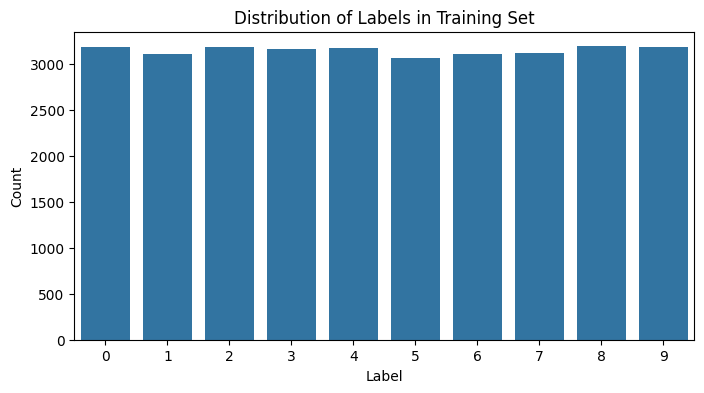

In [7]:
import seaborn as sns

plt.figure(figsize=(8,4))
sns.countplot(x=ytrain)
plt.title("Distribution of Labels in Training Set")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

### 🖼️ Visual Inspection of Sample Images from Training Set

To better understand the dataset, we visualized 25 randomly selected images from the training set.

Each image is a **32x32 grayscale representation** of a fashion item, with its corresponding label shown above. This provides useful insight into:

- The **visual quality** of the images.
- The **variety of classes** present in the dataset.
- Whether the label assignments seem reasonable at a glance.

Visual inspection like this is a valuable step before training models, especially for verifying that the data preprocessing (e.g., reshaping) worked correctly.


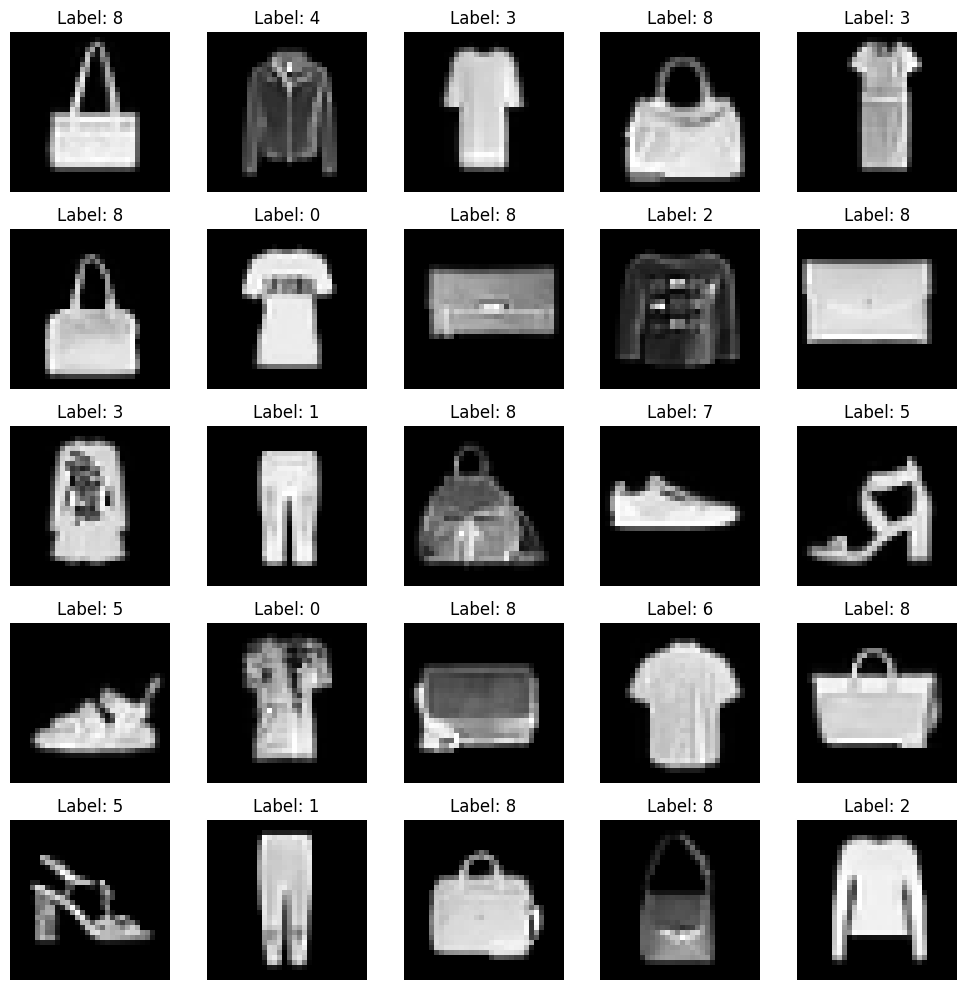

In [8]:
images = Xtrain.values.reshape(-1, 32, 32)
labels = ytrain.values
plt.figure(figsize=(10,10))
for i in range(25):
    idx = np.random.randint(len(images))
    plt.subplot(5,5,i+1)
    plt.imshow(images[idx], cmap='gray')
    plt.title(f"Label: {labels[idx]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

### 🧠 MyNN: Customizable Fully Connected Neural Network

The `MyNN` class defines a flexible multi-layer perceptron (MLP) in PyTorch with support for:

- ✅ Customizable layer sizes (`layer_sizes`)
- ✅ Per-layer activation functions (`activations`)
- ✅ Optional dropout regularization (`dropout_rates`)

**Key Features:**
- Layers are constructed using a loop over `layer_sizes`.
- Each hidden layer is followed by:
  - a non-linear activation (ReLU, Sigmoid, or Tanh),
  - a dropout layer (if provided).
- Dropout is disabled by default if `dropout_rates=None`.

**Example Use Case:**
```python
model = MyNN(layer_sizes=[1024, 256, 128, 10],
             activations=["relu", "tanh", "relu"],
             dropout_rates=[0.3, 0.2, 0.0])


In [9]:

class MyNN(nn.Module):
    def __init__(self, layer_sizes, activations, dropout_rates=None):
        super().__init__()

        self.layers = nn.ModuleList()
        self.dropout_layers = nn.ModuleList()

        # Handle dropout defaults
        if dropout_rates is None:
            dropout_rates = [0.0] * (len(layer_sizes) - 1)

        self.activation_functions = {
            "relu": F.relu,
            "sigmoid": torch.sigmoid,
            "tanh": torch.tanh
        }

        self.activations = activations

        # Construct layers
        for i in range(len(layer_sizes) - 1):
            self.layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            if i < len(dropout_rates):
                self.dropout_layers.append(nn.Dropout(dropout_rates[i]))

    def forward(self, x):
        for i in range(len(self.layers)):
            x = self.layers[i](x)
            if i < len(self.layers) - 1:
                act_name = self.activations[i]
                act_fn = self.activation_functions.get(act_name, F.relu)
                x = act_fn(x)
                x = self.dropout_layers[i](x)
        return x


### 🔧 `train_model()` and `evaluate_model()` – Function Descriptions

---

#### 🏋️‍♂️ `train_model()`

This function trains a PyTorch neural network model using a given optimizer, loss function, and data loader. It supports **L1** and **L2 regularization**, and automatically tracks the model that achieves the **best validation accuracy**.

**Parameters:**
- `model`: The PyTorch model to train.
- `train_loader`: DataLoader providing training data batches.
- `criterion`: The loss function (e.g. `nn.CrossEntropyLoss()`).
- `optimizer`: Optimizer used to update model weights (e.g. Adam, SGD).
- `epochs`: Number of training epochs (default is 10).
- `reg`: Regularization type: `"l1"`, `"l2"`, or `None`.
- `reg_lambda`: Regularization strength.
- `val_loader`: DataLoader for validation data.

**Functionality:**
- Performs forward and backward passes on training data.
- Adds regularization loss to the criterion loss if `reg` is set.
- Keeps track of average loss per epoch.
- Evaluates validation accuracy at the end of each epoch.
- Saves and restores the best-performing model parameters.

---

#### 📊 `evaluate_model()`

This function calculates the accuracy of a trained model on a validation or test set.

**Parameters:**
- `model`: The trained model to evaluate.
- `val_loader`: DataLoader providing validation or test data.

**Returns:**
- `acc`: Accuracy score as a float (correct predictions / total samples).

**Functionality:**
- Switches the model to evaluation mode.
- Disables gradient computation to improve efficiency.
- Iterates over the validation data, predicting labels and comparing them to ground truth.


In [10]:
import matplotlib.pyplot as plt

def print_func(train_losses):
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

In [67]:
def train_model(
    model,
    train_loader,
    criterion,
    optimizer,
    epochs=10,
    reg=None,
    reg_lambda=0.0,
    val_loader=None
):
    losses = []
    best_val_acc = 0
    best_model_state = model.state_dict()
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for xb, yb in train_loader:
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)

            # Apply regularization if enabled
            if reg is not None:
                reg_loss = torch.tensor(0.0, device=xb.device)
                for param in model.parameters():
                    if reg=="l1":
                        reg_loss += torch.linalg.vector_norm(param.flatten(), ord=1)
                    if reg=="l2":
                        reg_loss += torch.linalg.vector_norm(param.flatten(), ord=2)
                loss += reg_lambda * reg_loss

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

        
        acc = evaluate_model(model, val_loader)
        if acc > best_val_acc:
            best_val_acc = acc
            best_model_state = model.state_dict()
            

    
    model.load_state_dict(best_model_state)

    return losses


def evaluate_model(model, val_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            preds = model(xb)
            pred_labels = preds.argmax(dim=1)
            correct += (pred_labels == yb).sum().item()
            total += yb.size(0)

    acc = correct / total
    return acc

## 🔧 Hyperparameter Grid and Training Function Overview

### 🔢 Parameter Grid (param_grid)
This block sets up a **parameter grid** that defines different configurations of neural network architectures and activation functions. It allows systematic experimentation by combining:
- Different fully connected `layer_sizes`
- Different combinations of activation functions (e.g., `'relu'`, `'tanh'`, `'sigmoid'`)

The grid is expanded into all combinations using `ParameterGrid` from `sklearn`, enabling automated looping over model configurations during training.

---

### 🔄 `to_tensor` Function
This helper function ensures that any input data (Pandas DataFrame, NumPy array, etc.) is safely converted into a PyTorch tensor with the correct data type. It's useful for keeping the code flexible and compatible with multiple input formats.

---

### 🏋️ `train` Function
The `train` function encapsulates the **full training pipeline** for a given model and optimizer configuration. It performs the following tasks:
- Converts the training and validation data to PyTorch tensors.
- Wraps the data in `TensorDataset` objects and loads them with `DataLoader` to enable minibatch training.
- Sets up the loss function (`CrossEntropyLoss`) and calls the `train_model` function that performs the training over a number of epochs.
- Returns both the validation accuracy and training loss values, which can be used for model selection and evaluation.

This design makes it easy to plug in different models, optimizers, regularization options (like L1 or L2), and hyperparameters during experimentation.


In [50]:
from sklearn.model_selection import ParameterGrid

param_grid = {
    "layer_sizes": [
        [1024, 256, 128, 10],
        [1024, 512, 256, 10],
        [1024, 256, 10]
    ],
    "activation1": ["relu"],
    "activation2": ["tanh", "sigmoid"],
}

grid = ParameterGrid(param_grid)

In [48]:
from torch.utils.data import TensorDataset, DataLoader

def to_tensor(data, dtype):
    return torch.tensor(data.values if hasattr(data, "values") else data, dtype=dtype)

def train(Xtrain, ytrain, Xval, yval, model, optimizer, reg=None, reg_lambda=None, epochs=10):

    Xtrain_tensor = to_tensor(Xtrain, torch.float32)
    ytrain_tensor = to_tensor(ytrain, torch.long)
    Xval_tensor = to_tensor(Xval, torch.float32)
    yval_tensor = to_tensor(yval, torch.long)

    # Create datasets and loaders
    train_dataset = TensorDataset(Xtrain_tensor, ytrain_tensor)
    val_dataset = TensorDataset(Xval_tensor, yval_tensor)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64)

        
    criterion = nn.CrossEntropyLoss()

    train_losses = train_model(
        model,
        train_loader,
        criterion,
        optimizer,
        epochs=epochs,
        reg=reg,
        reg_lambda=reg_lambda,
        val_loader=val_loader
    )
    return evaluate_model(model, val_loader), train_losses

## 🔁 Grid Search for Hyperparameter Tuning (Default Setup)

In this block, we are performing a grid search over different hyperparameter configurations defined in the `grid`. For each combination of:
- `layer_sizes` (the architecture of the neural network),
- `activation functions` (combinations of activation1 and activation2),
- a default optimizer (`adam`),
- and no regularization (default `None` for `reg`, `reg_lambda`, and `dropout_rates`),

the model is trained and evaluated on a validation set.

Each model is:
- Instantiated with a specific combination of `layer_sizes` and `activations`.
- Trained using the `train()` function with default training settings.
- Evaluated for validation accuracy.

If a model achieves a better accuracy than previously seen, it is saved as the current best model, along with its configuration and training losses. This enables easy comparison and final selection of the most effective model setup.



Training with layers: [1024, 256, 128, 10], activations: ['relu', 'tanh'], optimizer: adam, regalurisation: None, reg_lambda:None, dropout_rates: None
Epoch 1/10, Loss: 1.2336
Epoch 2/10, Loss: 0.9677
Epoch 3/10, Loss: 0.9109
Epoch 4/10, Loss: 0.9149
Epoch 5/10, Loss: 0.8980
Epoch 6/10, Loss: 0.9526
Epoch 7/10, Loss: 0.8955
Epoch 8/10, Loss: 0.9222
Epoch 9/10, Loss: 0.9081
Epoch 10/10, Loss: 0.8730
Validation Accuracy: 0.6699

Training with layers: [1024, 512, 256, 10], activations: ['relu', 'tanh'], optimizer: adam, regalurisation: None, reg_lambda:None, dropout_rates: None
Epoch 1/10, Loss: 1.3212
Epoch 2/10, Loss: 1.1101
Epoch 3/10, Loss: 1.0003
Epoch 4/10, Loss: 1.0097
Epoch 5/10, Loss: 0.9693
Epoch 6/10, Loss: 1.0315
Epoch 7/10, Loss: 1.0475
Epoch 8/10, Loss: 1.0053
Epoch 9/10, Loss: 1.0131
Epoch 10/10, Loss: 1.0421
Validation Accuracy: 0.5954

Training with layers: [1024, 256, 10], activations: ['relu', 'tanh'], optimizer: adam, regalurisation: None, reg_lambda:None, dropout_rat

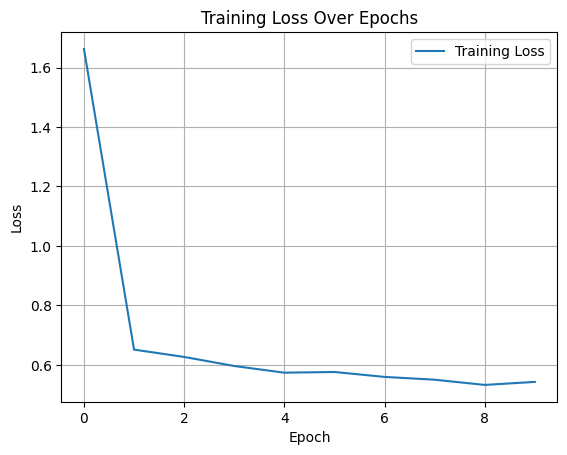

In [14]:
best_acc = 0
best_model = None
best_losses = []

dropout_rates = None
reg = None
reg_lambda = None
optim = "adam"

for params in grid:
    layer_sizes = params["layer_sizes"]
    
    activations = [params["activation1"], params["activation2"]][:len(layer_sizes) - 1]
    model = MyNN(layer_sizes=layer_sizes, activations=activations, dropout_rates=dropout_rates)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    print(f"\nTraining with layers: {layer_sizes}, activations: {activations}, optimizer: {optim}, regalurisation: {reg}, reg_lambda:{reg_lambda}, dropout_rates: {dropout_rates}")
    
    acc, train_losses = train(Xtrain, ytrain, Xval, yval, model, optimizer, reg=reg, reg_lambda=reg_lambda)

    if acc > best_acc:
        best_acc = acc
        best_model = {
            "layer_sizes": layer_sizes,
            "activations": activations,
            "optimizer": optim,
            "reg": reg,
            "reg_lambda": reg_lambda,
            "dropout_rates": dropout_rates
        }
        best_losses = train_losses
    print(f"Validation Accuracy: {acc:.4f}")


print(f"\n Best model: {best_model} with accuracy: {best_acc:.4f}")
print_func(best_losses)


## 🧮 Feature Scaling with MinMaxScaler

In this step, I applied `MinMaxScaler` from `sklearn.preprocessing` to normalize the input features of the dataset.

MinMax scaling transforms the features by scaling them to a fixed range, typically [0, 1]. This is particularly important for neural networks, where having input values in a similar range helps the model converge faster and improves stability.

### Process:
- `fit_transform` is applied to the training data to compute the minimum and maximum values and scale the data accordingly.
- `transform` is then applied to the validation and test sets using the same parameters to ensure consistency.

This normalization is done before training the model and is crucial for achieving optimal model performance.


In [15]:
from  sklearn.preprocessing import StandardScaler,MinMaxScaler
minmax = MinMaxScaler()
Xtrain_minmax = minmax.fit_transform(Xtrain)
Xval_minmax = minmax.transform(Xval)
Xtest_minmax = minmax.transform(Xtest)


Training with layers: [1024, 256, 128, 10], activations: ['relu', 'tanh'], optimizer: adam, regalurisation: None, reg_lambda:None, dropout_rates: None
Epoch 1/10, Loss: 0.7729
Epoch 2/10, Loss: 0.5555
Epoch 3/10, Loss: 0.4983
Epoch 4/10, Loss: 0.4613
Epoch 5/10, Loss: 0.4334
Epoch 6/10, Loss: 0.4079
Epoch 7/10, Loss: 0.3847
Epoch 8/10, Loss: 0.3725
Epoch 9/10, Loss: 0.3515
Epoch 10/10, Loss: 0.3358
Validation Accuracy: 0.8439

Training with layers: [1024, 512, 256, 10], activations: ['relu', 'tanh'], optimizer: adam, regalurisation: None, reg_lambda:None, dropout_rates: None
Epoch 1/10, Loss: 0.7290
Epoch 2/10, Loss: 0.5420
Epoch 3/10, Loss: 0.4816
Epoch 4/10, Loss: 0.4394
Epoch 5/10, Loss: 0.4116
Epoch 6/10, Loss: 0.3911
Epoch 7/10, Loss: 0.3630
Epoch 8/10, Loss: 0.3457
Epoch 9/10, Loss: 0.3284
Epoch 10/10, Loss: 0.3123
Validation Accuracy: 0.8445

Training with layers: [1024, 256, 10], activations: ['relu', 'tanh'], optimizer: adam, regalurisation: None, reg_lambda:None, dropout_rat

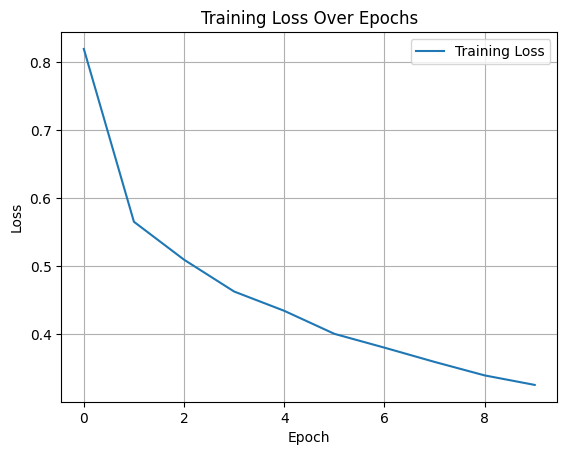

In [16]:
best_acc = 0
best_model = None
best_losses = []

dropout_rates = None
reg = None
reg_lambda = None
optim = "adam"

for params in grid:
    layer_sizes = params["layer_sizes"]
    
    activations = [params["activation1"], params["activation2"]][:len(layer_sizes) - 1]
    model = MyNN(layer_sizes=layer_sizes, activations=activations, dropout_rates=dropout_rates)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    print(f"\nTraining with layers: {layer_sizes}, activations: {activations}, optimizer: {optim}, regalurisation: {reg}, reg_lambda:{reg_lambda}, dropout_rates: {dropout_rates}")
    
    acc, train_losses = train(Xtrain_minmax, ytrain, Xval_minmax, yval, model, optimizer, reg=reg, reg_lambda=reg_lambda)

    if acc > best_acc:
        best_acc = acc
        best_model = {
            "layer_sizes": layer_sizes,
            "activations": activations,
            "optimizer": optim,
            "reg": reg,
            "reg_lambda": reg_lambda,
            "dropout_rates": dropout_rates
        }
        best_losses = train_losses
    print(f"Validation Accuracy: {acc:.4f}")


print(f"\n Best model: {best_model} with accuracy: {best_acc:.4f}")
print_func(best_losses)


## ⚖️ Feature Scaling with StandardScaler

In this section, I applied `StandardScaler` from `sklearn.preprocessing` to normalize the input features of the dataset.

Unlike `MinMaxScaler`, which scales data to a fixed range, `StandardScaler` standardizes features by removing the mean and scaling to unit variance. This results in each feature having zero mean and unit variance, which is often beneficial for algorithms that assume such distribution.

### Why it's used:
- It helps the model converge faster.
- Prevents features with larger numerical ranges from dominating others.

### Implementation details:
- `fit_transform()` is applied to the training set to learn the scaling parameters (mean and std).
- `transform()` is then used on the validation and test sets to scale them using the same parameters from the training data.


In [17]:
standart = StandardScaler()

Xtrain_standart = standart.fit_transform(Xtrain)
Xval_standart = standart.transform(Xval)
Xtest_standart = standart.transform(Xtest)


Training with layers: [1024, 256, 128, 10], activations: ['relu', 'tanh'], optimizer: adam, regalurisation: None, reg_lambda:None, dropout_rates: None
Epoch 1/10, Loss: 0.6972
Epoch 2/10, Loss: 0.5222
Epoch 3/10, Loss: 0.4658
Epoch 4/10, Loss: 0.4287
Epoch 5/10, Loss: 0.4023
Epoch 6/10, Loss: 0.3903
Epoch 7/10, Loss: 0.3658
Epoch 8/10, Loss: 0.3507
Epoch 9/10, Loss: 0.3373
Epoch 10/10, Loss: 0.3289
Validation Accuracy: 0.8318

Training with layers: [1024, 512, 256, 10], activations: ['relu', 'tanh'], optimizer: adam, regalurisation: None, reg_lambda:None, dropout_rates: None
Epoch 1/10, Loss: 0.6846
Epoch 2/10, Loss: 0.5250
Epoch 3/10, Loss: 0.4712
Epoch 4/10, Loss: 0.4413
Epoch 5/10, Loss: 0.4211
Epoch 6/10, Loss: 0.4013
Epoch 7/10, Loss: 0.3891
Epoch 8/10, Loss: 0.3783
Epoch 9/10, Loss: 0.3670
Epoch 10/10, Loss: 0.3626
Validation Accuracy: 0.8355

Training with layers: [1024, 256, 10], activations: ['relu', 'tanh'], optimizer: adam, regalurisation: None, reg_lambda:None, dropout_rat

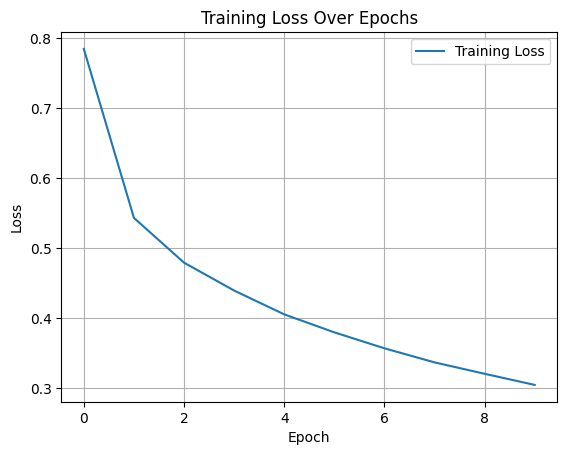

In [18]:
best_acc = 0
best_model = None
best_losses = []

dropout_rates = None
reg = None
reg_lambda = None
optim = "adam"

for params in grid:
    layer_sizes = params["layer_sizes"]
    
    activations = [params["activation1"], params["activation2"]][:len(layer_sizes) - 1]
    model = MyNN(layer_sizes=layer_sizes, activations=activations, dropout_rates=dropout_rates)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    print(f"\nTraining with layers: {layer_sizes}, activations: {activations}, optimizer: {optim}, regalurisation: {reg}, reg_lambda:{reg_lambda}, dropout_rates: {dropout_rates}")
    
    acc, train_losses = train(Xtrain_standart, ytrain, Xval_standart, yval, model, optimizer, reg=reg, reg_lambda=reg_lambda)

    if acc > best_acc:
        best_acc = acc
        best_model = {
            "layer_sizes": layer_sizes,
            "activations": activations,
            "optimizer": optim,
            "reg": reg,
            "reg_lambda": reg_lambda,
            "dropout_rates": dropout_rates
        }
        best_losses = train_losses
    print(f"Validation Accuracy: {acc:.4f}")


print(f"\n Best model: {best_model} with accuracy: {best_acc:.4f}")
print_func(best_losses)


## ✅ Best Performing Model Summary

After testing multiple configurations using different combinations of:
- layer sizes
- activation functions
- optimizers

📈 **The best results were achieved using a Standard Scaled dataset**.

The configuration that led to the highest validation accuracy was:
- **Layer sizes:** `[1024, 256, 128, 10]`
- **Activations:** `['relu', 'sigmoid']`
- **Optimizer:** `Adam`
- **Scaler:** `StandardScaler`

🟩 **Validation Accuracy:** `0.8503`

This suggests that using `StandardScaler` for preprocessing can significantly enhance performance by normalizing feature distributions and improving optimization dynamics.


## ⚙️ Different Optimizers

In this section, we explore the impact of **different optimization algorithms** on model performance. Specifically, we compare:

- `SGD` (Stochastic Gradient Descent)
- `RMSprop`
- (`Adam` already tested before)

Each optimizer updates model weights differently, affecting training dynamics, convergence speed, and final accuracy. We keep the rest of the parameters (architecture, activations, dropout, regularization) constant to isolate the effect of the optimizer.

By looping through the grid with different optimizers, we aim to find which optimizer helps the model generalize best on the validation set.



Training with layers: [1024, 256, 128, 10], activations: ['relu', 'tanh'], optimizer: SGD, regalurisation: None, reg_lambda:None, dropout_rates: None
Epoch 1/10, Loss: 2.2740
Epoch 2/10, Loss: 2.2182
Epoch 3/10, Loss: 2.1520
Epoch 4/10, Loss: 2.0660
Epoch 5/10, Loss: 1.9548
Epoch 6/10, Loss: 1.8270
Epoch 7/10, Loss: 1.7043
Epoch 8/10, Loss: 1.6004
Epoch 9/10, Loss: 1.5168
Epoch 10/10, Loss: 1.4485
Validation Accuracy: 0.5712

Training with layers: [1024, 512, 256, 10], activations: ['relu', 'tanh'], optimizer: SGD, regalurisation: None, reg_lambda:None, dropout_rates: None
Epoch 1/10, Loss: 2.2655
Epoch 2/10, Loss: 2.1987
Epoch 3/10, Loss: 2.1193
Epoch 4/10, Loss: 2.0140
Epoch 5/10, Loss: 1.8812
Epoch 6/10, Loss: 1.7413
Epoch 7/10, Loss: 1.6183
Epoch 8/10, Loss: 1.5201
Epoch 9/10, Loss: 1.4417
Epoch 10/10, Loss: 1.3789
Validation Accuracy: 0.5997

Training with layers: [1024, 256, 10], activations: ['relu', 'tanh'], optimizer: SGD, regalurisation: None, reg_lambda:None, dropout_rates:

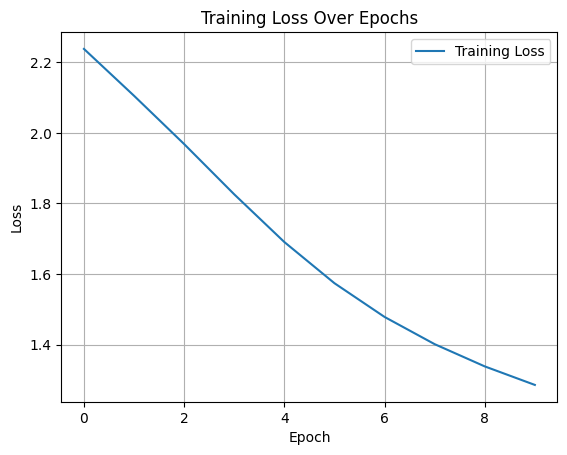

In [19]:
best_acc = 0
best_model = None
best_losses = []

dropout_rates = None
reg = None
reg_lambda = None
optim = "SGD"

for params in grid:
    layer_sizes = params["layer_sizes"]
    
    activations = [params["activation1"], params["activation2"]][:len(layer_sizes) - 1]
    model = MyNN(layer_sizes=layer_sizes, activations=activations, dropout_rates=dropout_rates)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
    
    print(f"\nTraining with layers: {layer_sizes}, activations: {activations}, optimizer: {optim}, regalurisation: {reg}, reg_lambda:{reg_lambda}, dropout_rates: {dropout_rates}")
    
    acc, train_losses = train(Xtrain_standart, ytrain, Xval_standart, yval, model, optimizer, reg=reg, reg_lambda=reg_lambda)

    if acc > best_acc:
        best_acc = acc
        best_model = {
            "layer_sizes": layer_sizes,
            "activations": activations,
            "optimizer": optim,
            "reg": reg,
            "reg_lambda": reg_lambda,
            "dropout_rates": dropout_rates
        }
        best_losses = train_losses
    print(f"Validation Accuracy: {acc:.4f}")


print(f"\n Best model: {best_model} with accuracy: {best_acc:.4f}")
print_func(best_losses)



Training with layers: [1024, 256, 128, 10], activations: ['relu', 'tanh'], optimizer: RMSprop, regalurisation: None, reg_lambda:None, dropout_rates: None
Epoch 1/10, Loss: 0.7390
Epoch 2/10, Loss: 0.5516
Epoch 3/10, Loss: 0.4972
Epoch 4/10, Loss: 0.4589
Epoch 5/10, Loss: 0.4285
Epoch 6/10, Loss: 0.4060
Epoch 7/10, Loss: 0.3831
Epoch 8/10, Loss: 0.3669
Epoch 9/10, Loss: 0.3489
Epoch 10/10, Loss: 0.3345
Validation Accuracy: 0.8140

Training with layers: [1024, 512, 256, 10], activations: ['relu', 'tanh'], optimizer: RMSprop, regalurisation: None, reg_lambda:None, dropout_rates: None
Epoch 1/10, Loss: 0.7674
Epoch 2/10, Loss: 0.5506
Epoch 3/10, Loss: 0.4881
Epoch 4/10, Loss: 0.4509
Epoch 5/10, Loss: 0.4201
Epoch 6/10, Loss: 0.3926
Epoch 7/10, Loss: 0.3743
Epoch 8/10, Loss: 0.3533
Epoch 9/10, Loss: 0.3355
Epoch 10/10, Loss: 0.3172
Validation Accuracy: 0.8367

Training with layers: [1024, 256, 10], activations: ['relu', 'tanh'], optimizer: RMSprop, regalurisation: None, reg_lambda:None, dr

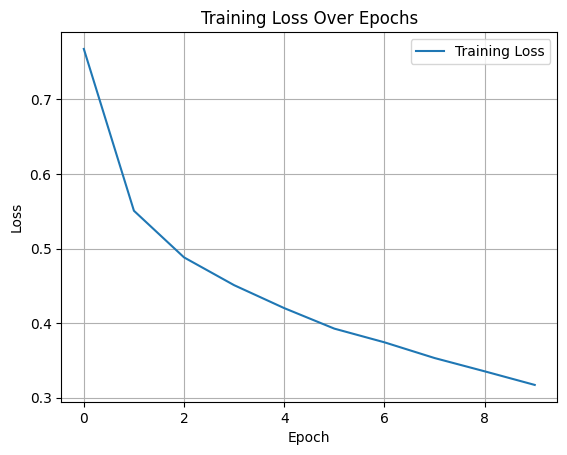

In [20]:
best_acc = 0
best_model = None
best_losses = []

dropout_rates = None
reg = None
reg_lambda = None
optim = "RMSprop"

for params in grid:
    layer_sizes = params["layer_sizes"]
    
    activations = [params["activation1"], params["activation2"]][:len(layer_sizes) - 1]
    model = MyNN(layer_sizes=layer_sizes, activations=activations, dropout_rates=dropout_rates)
    optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
    
    print(f"\nTraining with layers: {layer_sizes}, activations: {activations}, optimizer: {optim}, regalurisation: {reg}, reg_lambda:{reg_lambda}, dropout_rates: {dropout_rates}")
    
    acc, train_losses = train(Xtrain_standart, ytrain, Xval_standart, yval, model, optimizer, reg=reg, reg_lambda=reg_lambda)

    if acc > best_acc:
        best_acc = acc
        best_model = {
            "layer_sizes": layer_sizes,
            "activations": activations,
            "optimizer": optim,
            "reg": reg,
            "reg_lambda": reg_lambda,
            "dropout_rates": dropout_rates
        }
        best_losses = train_losses
    print(f"Validation Accuracy: {acc:.4f}")


print(f"\n Best model: {best_model} with accuracy: {best_acc:.4f}")
print_func(best_losses)


### 🔍 RMSprop vs Adam Performance

Although the model trained with **RMSprop** optimizer achieved relatively strong results with a validation accuracy of `0.8367`, it **did not surpass** the previously observed best performance.

The highest accuracy was still achieved using the **Adam** optimizer on the Standard Scaled dataset, which yielded an accuracy of **0.8503**.

This suggests that while RMSprop can be effective, **Adam remains the more robust choice** for this task and dataset configuration.

### 🧪 Regularisation with No Dropouts

In this experiment, we are testing **L1** and **L2 regularisation techniques** **without using dropout**.

- The model is trained using the **Adam optimizer**.
- The dropout rate is explicitly set to `None`, meaning no neurons are dropped during training.
- We loop through a small range of regularisation strengths (`reg_lambda`) and apply them using either **L1** or **L2 norms** on the model weights.
- The goal is to evaluate whether weight regularisation alone can provide sufficient generalization benefit, without the need for dropout-based regularisation.

This helps us understand the isolated effect of **L1/L2 regularisation** on overfitting and model performance.



Training with layers: [1024, 256, 128, 10], activations: ['relu', 'tanh'], optimizer: adam, regalurisation: l1, reg_lambda:0.1, dropout_rates: None
Epoch 1/10, Loss: 21.3772
Epoch 2/10, Loss: 6.0282
Epoch 3/10, Loss: 6.0286
Epoch 4/10, Loss: 6.0278
Epoch 5/10, Loss: 6.0279
Epoch 6/10, Loss: 6.0284
Epoch 7/10, Loss: 6.0276
Epoch 8/10, Loss: 6.0278
Epoch 9/10, Loss: 6.0275
Epoch 10/10, Loss: 6.0277
Validation Accuracy: 0.1030

Training with layers: [1024, 512, 256, 10], activations: ['relu', 'tanh'], optimizer: adam, regalurisation: l1, reg_lambda:0.1, dropout_rates: None
Epoch 1/10, Loss: 41.5249
Epoch 2/10, Loss: 10.5739
Epoch 3/10, Loss: 10.5737
Epoch 4/10, Loss: 10.5721
Epoch 5/10, Loss: 10.5726
Epoch 6/10, Loss: 10.5735
Epoch 7/10, Loss: 10.5714
Epoch 8/10, Loss: 10.5717
Epoch 9/10, Loss: 10.5710
Epoch 10/10, Loss: 10.5714
Validation Accuracy: 0.0961

Training with layers: [1024, 256, 10], activations: ['relu', 'tanh'], optimizer: adam, regalurisation: l1, reg_lambda:0.1, dropout_r

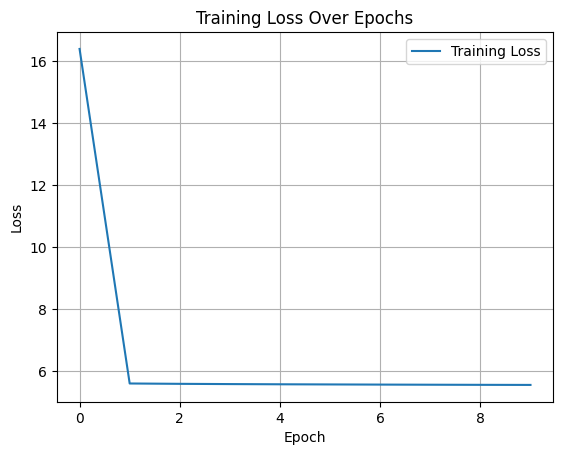


Training with layers: [1024, 256, 128, 10], activations: ['relu', 'tanh'], optimizer: adam, regalurisation: l1, reg_lambda:0.01, dropout_rates: None
Epoch 1/10, Loss: 4.2153
Epoch 2/10, Loss: 2.6717
Epoch 3/10, Loss: 2.6717
Epoch 4/10, Loss: 2.6716
Epoch 5/10, Loss: 2.6715
Epoch 6/10, Loss: 2.6715
Epoch 7/10, Loss: 2.6714
Epoch 8/10, Loss: 2.6713
Epoch 9/10, Loss: 2.6713
Epoch 10/10, Loss: 2.6712
Validation Accuracy: 0.1013

Training with layers: [1024, 512, 256, 10], activations: ['relu', 'tanh'], optimizer: adam, regalurisation: l1, reg_lambda:0.01, dropout_rates: None
Epoch 1/10, Loss: 6.2209
Epoch 2/10, Loss: 3.1232
Epoch 3/10, Loss: 3.1230
Epoch 4/10, Loss: 3.1226
Epoch 5/10, Loss: 3.1224
Epoch 6/10, Loss: 3.1224
Epoch 7/10, Loss: 3.1220
Epoch 8/10, Loss: 3.1219
Epoch 9/10, Loss: 3.1218
Epoch 10/10, Loss: 3.1216
Validation Accuracy: 0.0959

Training with layers: [1024, 256, 10], activations: ['relu', 'tanh'], optimizer: adam, regalurisation: l1, reg_lambda:0.01, dropout_rates: No

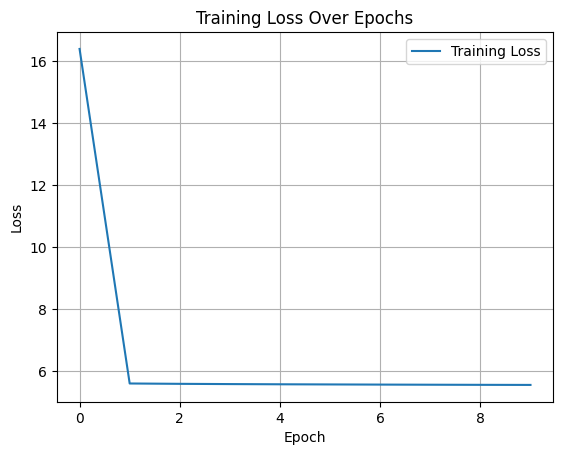

In [21]:
best_acc = 0
best_model = None
best_losses = []

dropout_rates = None
reg = "l1"
reg_lambda = None
optim = "adam"

for reg_lambda in [0.1, 0.01]:
    for params in grid:
        layer_sizes = params["layer_sizes"]
        
        activations = [params["activation1"], params["activation2"]][:len(layer_sizes) - 1]
        model = MyNN(layer_sizes=layer_sizes, activations=activations, dropout_rates=dropout_rates)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        
        print(f"\nTraining with layers: {layer_sizes}, activations: {activations}, optimizer: {optim}, regalurisation: {reg}, reg_lambda:{reg_lambda}, dropout_rates: {dropout_rates}")
        
        acc, train_losses = train(Xtrain_minmax, ytrain, Xval_minmax, yval, model, optimizer, reg=reg, reg_lambda=reg_lambda)
    
        if acc > best_acc:
            best_acc = acc
            best_model = {
                "layer_sizes": layer_sizes,
                "activations": activations,
                "optimizer": optim,
                "reg": reg,
                "reg_lambda": reg_lambda,
                "dropout_rates": dropout_rates
            }
            best_losses = train_losses
        print(f"Validation Accuracy: {acc:.4f}")
    
    
    print(f"\n Best model: {best_model} with accuracy: {best_acc:.4f}")
    print_func(best_losses)



Training with layers: [1024, 256, 128, 10], activations: ['relu', 'tanh'], optimizer: adam, regalurisation: l2, reg_lambda:0.1, dropout_rates: None
Epoch 1/10, Loss: 1.9686
Epoch 2/10, Loss: 1.7848
Epoch 3/10, Loss: 1.7691
Epoch 4/10, Loss: 1.7598
Epoch 5/10, Loss: 1.7589
Epoch 6/10, Loss: 1.7541
Epoch 7/10, Loss: 1.7489
Epoch 8/10, Loss: 1.7480
Epoch 9/10, Loss: 1.7457
Epoch 10/10, Loss: 1.7468
Validation Accuracy: 0.6992

Training with layers: [1024, 512, 256, 10], activations: ['relu', 'tanh'], optimizer: adam, regalurisation: l2, reg_lambda:0.1, dropout_rates: None
Epoch 1/10, Loss: 2.0062
Epoch 2/10, Loss: 1.7805
Epoch 3/10, Loss: 1.7603
Epoch 4/10, Loss: 1.7568
Epoch 5/10, Loss: 1.7522
Epoch 6/10, Loss: 1.7445
Epoch 7/10, Loss: 1.7492
Epoch 8/10, Loss: 1.7430
Epoch 9/10, Loss: 1.7439
Epoch 10/10, Loss: 1.7410
Validation Accuracy: 0.7099

Training with layers: [1024, 256, 10], activations: ['relu', 'tanh'], optimizer: adam, regalurisation: l2, reg_lambda:0.1, dropout_rates: None


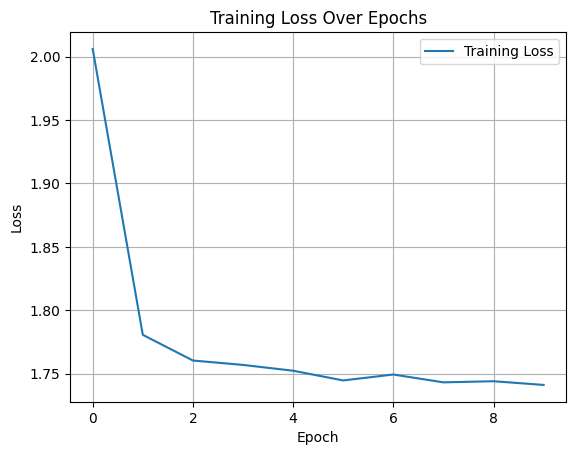


Training with layers: [1024, 256, 128, 10], activations: ['relu', 'tanh'], optimizer: adam, regalurisation: l2, reg_lambda:0.01, dropout_rates: None
Epoch 1/10, Loss: 0.9877
Epoch 2/10, Loss: 0.8126
Epoch 3/10, Loss: 0.7724
Epoch 4/10, Loss: 0.7568
Epoch 5/10, Loss: 0.7366
Epoch 6/10, Loss: 0.7238
Epoch 7/10, Loss: 0.7155
Epoch 8/10, Loss: 0.7061
Epoch 9/10, Loss: 0.6956
Epoch 10/10, Loss: 0.6958
Validation Accuracy: 0.8326

Training with layers: [1024, 512, 256, 10], activations: ['relu', 'tanh'], optimizer: adam, regalurisation: l2, reg_lambda:0.01, dropout_rates: None
Epoch 1/10, Loss: 0.9780
Epoch 2/10, Loss: 0.8215
Epoch 3/10, Loss: 0.7891
Epoch 4/10, Loss: 0.7704
Epoch 5/10, Loss: 0.7503
Epoch 6/10, Loss: 0.7402
Epoch 7/10, Loss: 0.7228
Epoch 8/10, Loss: 0.7202
Epoch 9/10, Loss: 0.7102
Epoch 10/10, Loss: 0.7016
Validation Accuracy: 0.8252

Training with layers: [1024, 256, 10], activations: ['relu', 'tanh'], optimizer: adam, regalurisation: l2, reg_lambda:0.01, dropout_rates: No

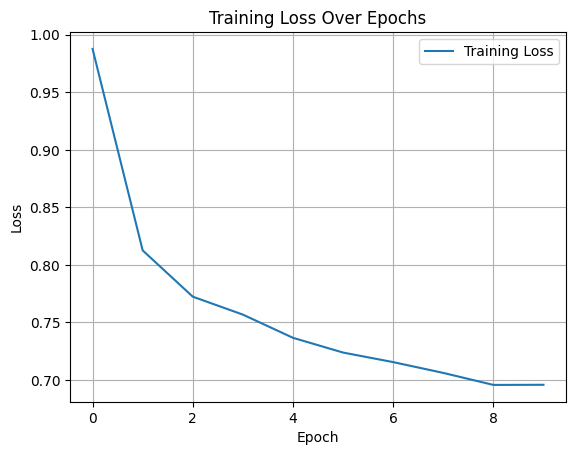

In [22]:
best_acc = 0
best_model = None
best_losses = []

dropout_rates = None
reg = "l2"
reg_lambda = None
optim = "adam"

for reg_lambda in [0.1, 0.01]:
    for params in grid:
        layer_sizes = params["layer_sizes"]
        
        activations = [params["activation1"], params["activation2"]][:len(layer_sizes) - 1]
        model = MyNN(layer_sizes=layer_sizes, activations=activations, dropout_rates=dropout_rates)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        
        print(f"\nTraining with layers: {layer_sizes}, activations: {activations}, optimizer: {optim}, regalurisation: {reg}, reg_lambda:{reg_lambda}, dropout_rates: {dropout_rates}")
        
        acc, train_losses = train(Xtrain_minmax, ytrain, Xval_minmax, yval, model, optimizer, reg=reg, reg_lambda=reg_lambda)
    
        if acc > best_acc:
            best_acc = acc
            best_model = {
                "layer_sizes": layer_sizes,
                "activations": activations,
                "optimizer": optim,
                "reg": reg,
                "reg_lambda": reg_lambda,
                "dropout_rates": dropout_rates
            }
            best_losses = train_losses
        print(f"Validation Accuracy: {acc:.4f}")
    
    
    print(f"\n Best model: {best_model} with accuracy: {best_acc:.4f}")
    print_func(best_losses)


# Regularisation with dropouts


Training with layers: [1024, 256, 128, 10], activations: ['relu', 'tanh'], optimizer: adam, regalurisation: l1, reg_lambda:0.1, dropout_rates: [0.2, 0.3]
Epoch 1/10, Loss: 21.3599
Epoch 2/10, Loss: 6.0218
Epoch 3/10, Loss: 6.0222
Epoch 4/10, Loss: 6.0213
Epoch 5/10, Loss: 6.0214
Epoch 6/10, Loss: 6.0219
Epoch 7/10, Loss: 6.0210
Epoch 8/10, Loss: 6.0214
Epoch 9/10, Loss: 6.0208
Epoch 10/10, Loss: 6.0211
Validation Accuracy: 0.0966

Training with layers: [1024, 512, 256, 10], activations: ['relu', 'tanh'], optimizer: adam, regalurisation: l1, reg_lambda:0.1, dropout_rates: [0.2, 0.3]
Epoch 1/10, Loss: 41.4863
Epoch 2/10, Loss: 10.5724
Epoch 3/10, Loss: 10.5719
Epoch 4/10, Loss: 10.5706
Epoch 5/10, Loss: 10.5709
Epoch 6/10, Loss: 10.5720
Epoch 7/10, Loss: 10.5698
Epoch 8/10, Loss: 10.5702
Epoch 9/10, Loss: 10.5694
Epoch 10/10, Loss: 10.5696
Validation Accuracy: 0.1013

Training with layers: [1024, 256, 10], activations: ['relu', 'tanh'], optimizer: adam, regalurisation: l1, reg_lambda:0.

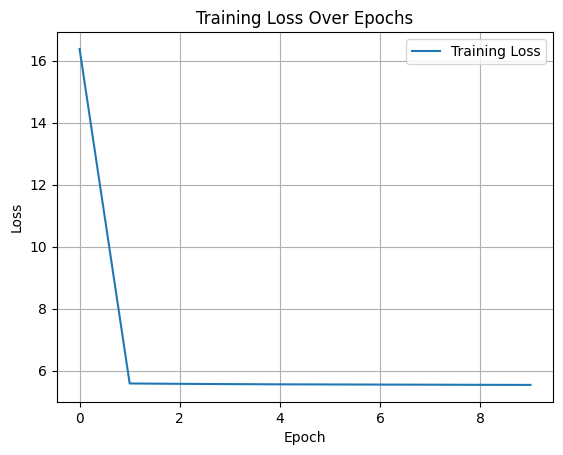


Training with layers: [1024, 256, 128, 10], activations: ['relu', 'tanh'], optimizer: adam, regalurisation: l1, reg_lambda:0.01, dropout_rates: [0.2, 0.3]
Epoch 1/10, Loss: 4.2150
Epoch 2/10, Loss: 2.6711
Epoch 3/10, Loss: 2.6710
Epoch 4/10, Loss: 2.6709
Epoch 5/10, Loss: 2.6708
Epoch 6/10, Loss: 2.6709
Epoch 7/10, Loss: 2.6708
Epoch 8/10, Loss: 2.6708
Epoch 9/10, Loss: 2.6707
Epoch 10/10, Loss: 2.6706
Validation Accuracy: 0.0961

Training with layers: [1024, 512, 256, 10], activations: ['relu', 'tanh'], optimizer: adam, regalurisation: l1, reg_lambda:0.01, dropout_rates: [0.2, 0.3]
Epoch 1/10, Loss: 6.2233
Epoch 2/10, Loss: 3.1236
Epoch 3/10, Loss: 3.1233
Epoch 4/10, Loss: 3.1230
Epoch 5/10, Loss: 3.1228
Epoch 6/10, Loss: 3.1228
Epoch 7/10, Loss: 3.1224
Epoch 8/10, Loss: 3.1223
Epoch 9/10, Loss: 3.1222
Epoch 10/10, Loss: 3.1220
Validation Accuracy: 0.1030

Training with layers: [1024, 256, 10], activations: ['relu', 'tanh'], optimizer: adam, regalurisation: l1, reg_lambda:0.01, dropo

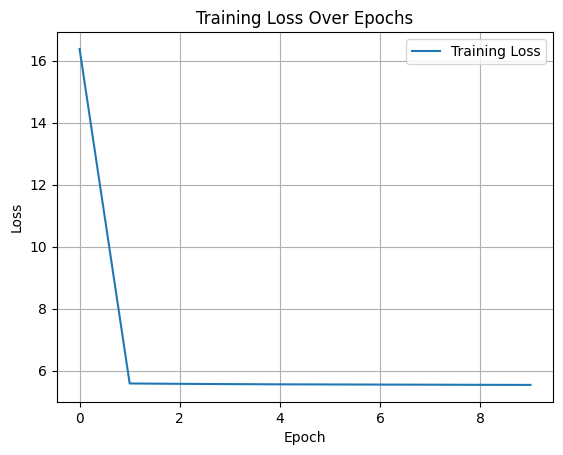

In [23]:
best_acc = 0
best_model = None
best_losses = []

dropout_rates = [0.2, 0.3]
reg = "l1"
reg_lambda = None
optim = "adam"

for reg_lambda in [0.1, 0.01]:
    for params in grid:
        layer_sizes = params["layer_sizes"]
        
        activations = [params["activation1"], params["activation2"]][:len(layer_sizes) - 1]
        model = MyNN(layer_sizes=layer_sizes, activations=activations, dropout_rates=dropout_rates)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        
        print(f"\nTraining with layers: {layer_sizes}, activations: {activations}, optimizer: {optim}, regalurisation: {reg}, reg_lambda:{reg_lambda}, dropout_rates: {dropout_rates}")
        
        acc, train_losses = train(Xtrain_minmax, ytrain, Xval_minmax, yval, model, optimizer, reg=reg, reg_lambda=reg_lambda)
    
        if acc > best_acc:
            best_acc = acc
            best_model = {
                "layer_sizes": layer_sizes,
                "activations": activations,
                "optimizer": optim,
                "reg": reg,
                "reg_lambda": reg_lambda,
                "dropout_rates": dropout_rates
            }
            best_losses = train_losses
        print(f"Validation Accuracy: {acc:.4f}")
    
    
    print(f"\n Best model: {best_model} with accuracy: {best_acc:.4f}")
    print_func(best_losses)



Training with layers: [1024, 256, 128, 10], activations: ['relu', 'tanh'], optimizer: adam, regalurisation: l2, reg_lambda:0.1, dropout_rates: [0.2, 0.3]
Epoch 1/10, Loss: 2.0379
Epoch 2/10, Loss: 1.8362
Epoch 3/10, Loss: 1.8255
Epoch 4/10, Loss: 1.8203
Epoch 5/10, Loss: 1.8162
Epoch 6/10, Loss: 1.8138
Epoch 7/10, Loss: 1.8177
Epoch 8/10, Loss: 1.8151
Epoch 9/10, Loss: 1.8123
Epoch 10/10, Loss: 1.8112
Validation Accuracy: 0.6764

Training with layers: [1024, 512, 256, 10], activations: ['relu', 'tanh'], optimizer: adam, regalurisation: l2, reg_lambda:0.1, dropout_rates: [0.2, 0.3]
Epoch 1/10, Loss: 2.0732
Epoch 2/10, Loss: 1.8331
Epoch 3/10, Loss: 1.8245
Epoch 4/10, Loss: 1.8131
Epoch 5/10, Loss: 1.8134
Epoch 6/10, Loss: 1.8104
Epoch 7/10, Loss: 1.8145
Epoch 8/10, Loss: 1.8124
Epoch 9/10, Loss: 1.8109
Epoch 10/10, Loss: 1.8140
Validation Accuracy: 0.6926

Training with layers: [1024, 256, 10], activations: ['relu', 'tanh'], optimizer: adam, regalurisation: l2, reg_lambda:0.1, dropout_

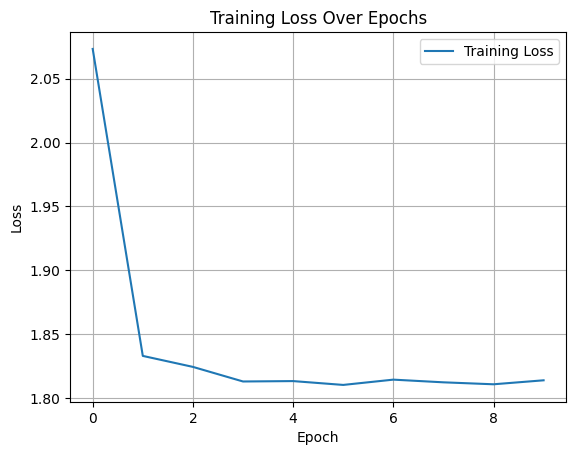


Training with layers: [1024, 256, 128, 10], activations: ['relu', 'tanh'], optimizer: adam, regalurisation: l2, reg_lambda:0.01, dropout_rates: [0.2, 0.3]
Epoch 1/10, Loss: 1.0494
Epoch 2/10, Loss: 0.8685
Epoch 3/10, Loss: 0.8345
Epoch 4/10, Loss: 0.8153
Epoch 5/10, Loss: 0.8023
Epoch 6/10, Loss: 0.7970
Epoch 7/10, Loss: 0.7922
Epoch 8/10, Loss: 0.7845
Epoch 9/10, Loss: 0.7775
Epoch 10/10, Loss: 0.7760
Validation Accuracy: 0.8250

Training with layers: [1024, 512, 256, 10], activations: ['relu', 'tanh'], optimizer: adam, regalurisation: l2, reg_lambda:0.01, dropout_rates: [0.2, 0.3]
Epoch 1/10, Loss: 1.0335
Epoch 2/10, Loss: 0.8778
Epoch 3/10, Loss: 0.8441
Epoch 4/10, Loss: 0.8279
Epoch 5/10, Loss: 0.8148
Epoch 6/10, Loss: 0.8039
Epoch 7/10, Loss: 0.7983
Epoch 8/10, Loss: 0.7981
Epoch 9/10, Loss: 0.7865
Epoch 10/10, Loss: 0.7822
Validation Accuracy: 0.8223

Training with layers: [1024, 256, 10], activations: ['relu', 'tanh'], optimizer: adam, regalurisation: l2, reg_lambda:0.01, dropo

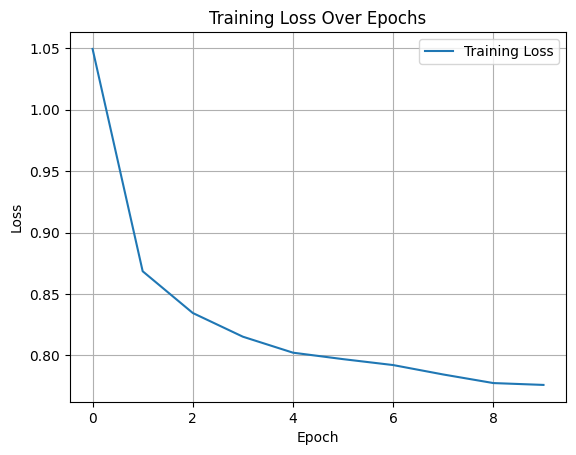

In [24]:
best_acc = 0
best_model = None
best_losses = []

dropout_rates = [0.2, 0.3]
reg = "l2"
reg_lambda = None
optim = "adam"

for reg_lambda in [0.1, 0.01]:
    for params in grid:
        layer_sizes = params["layer_sizes"]
        
        activations = [params["activation1"], params["activation2"]][:len(layer_sizes) - 1]
        model = MyNN(layer_sizes=layer_sizes, activations=activations, dropout_rates=dropout_rates)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        
        print(f"\nTraining with layers: {layer_sizes}, activations: {activations}, optimizer: {optim}, regalurisation: {reg}, reg_lambda:{reg_lambda}, dropout_rates: {dropout_rates}")
        
        acc, train_losses = train(Xtrain_minmax, ytrain, Xval_minmax, yval, model, optimizer, reg=reg, reg_lambda=reg_lambda)
    
        if acc > best_acc:
            best_acc = acc
            best_model = {
                "layer_sizes": layer_sizes,
                "activations": activations,
                "optimizer": optim,
                "reg": reg,
                "reg_lambda": reg_lambda,
                "dropout_rates": dropout_rates
            }
            best_losses = train_losses
        print(f"Validation Accuracy: {acc:.4f}")
    
    
    print(f"\n Best model: {best_model} with accuracy: {best_acc:.4f}")
    print_func(best_losses)


### Results of Regularizations

In this section, I experimented with different regularization strategies including **L1** and **L2**, both with and without dropout layers.

- When applying **L1 regularization without dropout**, the performance was significantly worse, achieving a validation accuracy as low as **0.10**, suggesting the model struggled to learn useful features under these constraints.
- With **L2 regularization without dropout**, the model performed moderately better, reaching a validation accuracy of around **0.70**.
- Adding **dropout layers** and combining them with **L2 regularization** (especially with a lower lambda value) noticeably improved generalization, reaching up to **0.82** in validation accuracy.

These results indicate that while some regularization strategies can degrade performance when too aggressive, a balanced approach—especially L2 with dropout—can lead to improved results by preventing overfitting while still enabling the model to learn complex patterns.


### Custom Convolutional Neural Network: `ConvNN`

This class defines a customizable Convolutional Neural Network with the following features:

#### Constructor: `__init__`

- **Parameters**:
  - `conv_channels`: A list of tuples indicating the input and output channels for each convolutional layer.
  - `kernel_sizes`: A list specifying the kernel size for each convolutional layer.
  - `activations`: Activation functions to use after each convolutional layer.
  - `dropout_rates`: Optional dropout rates for each conv layer to help prevent overfitting.
  - `use_batchnorm`: Flag to enable batch normalization (not implemented in this snippet but reserved).
  - `layer_sizes`: Fully connected (dense) layer sizes following the conv layers.

- **Layers**:
  - Builds a sequence of convolutional layers with optional dropout.
  - Automatically estimates the flattened size after conv layers assuming 32x32 input and 2x2 max pooling per conv.
  - Constructs fully connected layers based on `layer_sizes`.

- **Activation Functions**:
  - Supports `relu`, `sigmoid`, and `tanh`.

---

#### Forward Method: `forward`

- Automatically reshapes flat input to 2D if necessary.
- Applies each convolutional layer followed by:
  - activation,
  - max pooling,
  - optional dropout.
- Flattens the feature maps and passes the output through a sequence of fully connected layers.
- Applies activation to all layers except the last FC layer.

---

This implementation allows flexibility in designing CNN architectures by configuring depth, filter sizes, and dropout through parameters.


In [25]:

class ConvNN(nn.Module):
    def __init__(
        self,
        conv_channels=[(1, 32), (32, 64)],
        kernel_sizes=[3, 3],
        activations=["relu", "relu"],
        dropout_rates=None,
        use_batchnorm=True,
        layer_sizes=[256, 10]
    ):
        super().__init__()

        self.activations = activations
        self.use_dropout = dropout_rates is not None
        self.use_batchnorm = use_batchnorm

        self.conv_layers = nn.ModuleList()
        self.dropout_layers = nn.ModuleList()

        for i in range(len(conv_channels)):
            in_c, out_c = conv_channels[i]
            self.conv_layers.append(nn.Conv2d(in_c, out_c, kernel_size=kernel_sizes[i], padding=1))
            if self.use_dropout:
                rate = dropout_rates[i] if i < len(dropout_rates) else 0.0
                self.dropout_layers.append(nn.Dropout2d(rate))

        # Estimate flattened size after pooling
        pool_factor = 2 ** len(conv_channels)
        feature_map_size = 32 // pool_factor
        flattened_dim = conv_channels[-1][1] * feature_map_size * feature_map_size

        # Fully connected layers
        self.fc_layers = nn.ModuleList()
        prev_dim = flattened_dim
        for dim in layer_sizes:
            self.fc_layers.append(nn.Linear(prev_dim, dim))
            prev_dim = dim

        self.activation_functions = {
            "relu": F.relu,
            "sigmoid": torch.sigmoid,
            "tanh": torch.tanh
        }

    def forward(self, x):
        if x.dim() == 2:
            x = x.view(-1, 1, 32, 32)
        for i in range(len(self.conv_layers)):
            x = self.conv_layers[i](x)
            act_fn = self.activation_functions.get(self.activations[i], F.relu)
            x = act_fn(x)
            x = F.max_pool2d(x, 2)
            if self.use_dropout:
                x = self.dropout_layers[i](x)

        x = x.view(x.size(0), -1)

        for i, layer in enumerate(self.fc_layers):
            x = layer(x)
            if i < len(self.fc_layers) - 1:
                x = F.relu(x)

        return x


### Testing the Convolutional Neural Network (ConvNN) with Different Parameters

In this section, I am testing the custom convolutional neural network (`ConvNN`) with different architectural parameters. This includes varying the sizes of the fully connected layers (`layer_sizes`) and the activation functions used after each layer.

The goal is to evaluate how these design choices impact performance on the default training and validation datasets (`Xtrain`, `ytrain`).

The model is trained using the Adam optimizer with a learning rate of 0.001. This experiment helps determine which layer configurations and activations are best suited for this task before introducing additional complexity like normalization or regularization.


Training with layers: [1024, 256, 128, 10], activations: ['relu', 'relu'], optimizer: adam, regalurisation: None, reg_lambda:None, dropout_rates: None
Epoch 1/10, Loss: 0.6390
Epoch 2/10, Loss: 0.4042
Epoch 3/10, Loss: 0.3386
Epoch 4/10, Loss: 0.2897
Epoch 5/10, Loss: 0.2582
Epoch 6/10, Loss: 0.2260
Epoch 7/10, Loss: 0.1870
Epoch 8/10, Loss: 0.1659
Epoch 9/10, Loss: 0.1448
Epoch 10/10, Loss: 0.1298
Validation Accuracy: 0.8715


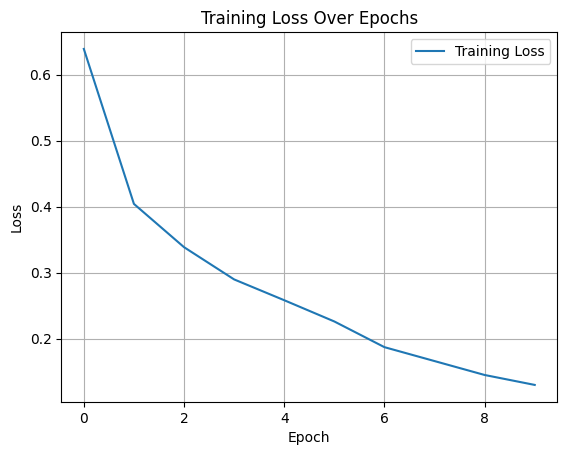

In [27]:
best_acc = 0
best_model = None
best_losses = []

dropout_rates = None
reg = None
reg_lambda = None
optim = "adam"
activations = ["relu", "relu"]
layer_sizes = [1024, 256, 128, 10]

model = ConvNN(layer_sizes=layer_sizes, activations=activations, dropout_rates=dropout_rates)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(f"\nTraining with layers: {layer_sizes}, activations: {activations}, optimizer: {optim}, regalurisation: {reg}, reg_lambda:{reg_lambda}, dropout_rates: {dropout_rates}")

acc, train_losses = train(Xtrain, ytrain, Xval, yval, model, optimizer, reg=reg, reg_lambda=reg_lambda)

print(f"Validation Accuracy: {acc:.4f}")

print_func(train_losses)



Training with layers: [1024, 512, 128], activations: ['relu', 'tanh'], optimizer: adam, regalurisation: None, reg_lambda:None, dropout_rates: None
Epoch 1/10, Loss: 0.5992
Epoch 2/10, Loss: 0.4100
Epoch 3/10, Loss: 0.3575
Epoch 4/10, Loss: 0.3112
Epoch 5/10, Loss: 0.2848
Epoch 6/10, Loss: 0.2567
Epoch 7/10, Loss: 0.2380
Epoch 8/10, Loss: 0.2204
Epoch 9/10, Loss: 0.2056
Epoch 10/10, Loss: 0.1934
Validation Accuracy: 0.8893


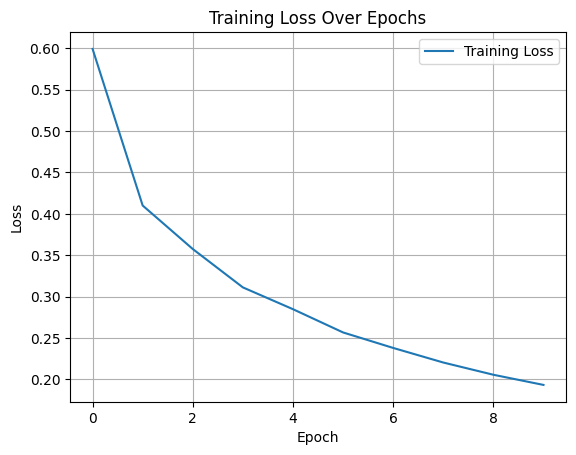

In [28]:
best_acc = 0
best_model = None
best_losses = []

dropout_rates = None
reg = None
reg_lambda = None
optim = "adam"
activations = ["relu", "tanh"]
layer_sizes = [1024, 512, 128]

model = ConvNN(layer_sizes=layer_sizes, activations=activations, dropout_rates=dropout_rates)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(f"\nTraining with layers: {layer_sizes}, activations: {activations}, optimizer: {optim}, regalurisation: {reg}, reg_lambda:{reg_lambda}, dropout_rates: {dropout_rates}")

acc, train_losses = train(Xtrain, ytrain, Xval, yval, model, optimizer, reg=reg, reg_lambda=reg_lambda)

print(f"Validation Accuracy: {acc:.4f}")

print_func(train_losses)



Training with layers: [128, 64], activations: ['relu', 'tanh'], optimizer: adam, regalurisation: None, reg_lambda:None, dropout_rates: None
Epoch 1/10, Loss: 0.6240
Epoch 2/10, Loss: 0.4573
Epoch 3/10, Loss: 0.3874
Epoch 4/10, Loss: 0.3454
Epoch 5/10, Loss: 0.3201
Epoch 6/10, Loss: 0.2916
Epoch 7/10, Loss: 0.2728
Epoch 8/10, Loss: 0.2517
Epoch 9/10, Loss: 0.2448
Epoch 10/10, Loss: 0.2267
Validation Accuracy: 0.8815


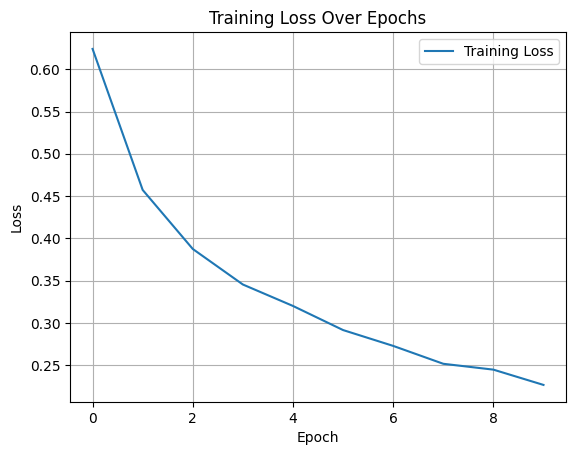

In [29]:
best_acc = 0
best_model = None
best_losses = []

dropout_rates = None
reg = None
reg_lambda = None
optim = "adam"
activations = ["relu", "tanh"]
layer_sizes = [128, 64]

model = ConvNN(layer_sizes=layer_sizes, activations=activations, dropout_rates=dropout_rates)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(f"\nTraining with layers: {layer_sizes}, activations: {activations}, optimizer: {optim}, regalurisation: {reg}, reg_lambda:{reg_lambda}, dropout_rates: {dropout_rates}")

acc, train_losses = train(Xtrain, ytrain, Xval, yval, model, optimizer, reg=reg, reg_lambda=reg_lambda)

print(f"Validation Accuracy: {acc:.4f}")

print_func(train_losses)


### Testing Best CNN Configuration with MinMax Scaler

In this section, we take the best-performing configuration from the previous experiments, which used the default dataset without normalization, and test it using **MinMax normalization**.

The configuration includes:
- **Layer sizes**: `[1024, 512, 128]`
- **Activations**: `['relu', 'tanh']`
- **Optimizer**: `Adam`

We now apply `MinMaxScaler` from `sklearn.preprocessing` to scale the input features to a range between 0 and 1. The purpose of this step is to observe whether normalization improves convergence speed, loss minimization, or final validation accuracy when applied to the same architecture and training setup.

This test allows us to directly compare the effectiveness of normalization strategies on CNN performance.



Training with layers: [1024, 512, 128], activations: ['relu', 'tanh'], optimizer: adam, regalurisation: None, reg_lambda:None, dropout_rates: None
Epoch 1/10, Loss: 0.7229
Epoch 2/10, Loss: 0.4105
Epoch 3/10, Loss: 0.3338
Epoch 4/10, Loss: 0.2831
Epoch 5/10, Loss: 0.2397
Epoch 6/10, Loss: 0.2014
Epoch 7/10, Loss: 0.1695
Epoch 8/10, Loss: 0.1409
Epoch 9/10, Loss: 0.1111
Epoch 10/10, Loss: 0.0906
Validation Accuracy: 0.8969


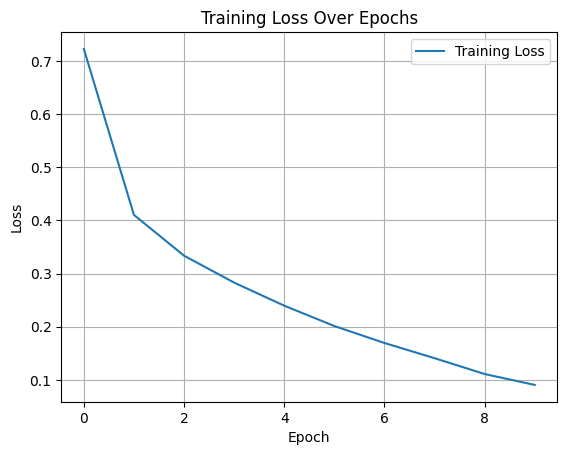

In [33]:
best_acc = 0
best_model = None
best_losses = []

dropout_rates = None
reg = None
reg_lambda = None
optim = "adam"
activations = ["relu", "tanh"]
layer_sizes = [1024, 512, 128]

model = ConvNN(layer_sizes=layer_sizes, activations=activations, dropout_rates=dropout_rates)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(f"\nTraining with layers: {layer_sizes}, activations: {activations}, optimizer: {optim}, regalurisation: {reg}, reg_lambda:{reg_lambda}, dropout_rates: {dropout_rates}")

acc, train_losses = train(Xtrain_minmax, ytrain, Xval_minmax, yval, model, optimizer, reg=reg, reg_lambda=reg_lambda)

print(f"Validation Accuracy: {acc:.4f}")

print_func(train_losses)


### Testing Best CNN Configuration with StandardScaler

After evaluating the best-performing CNN configuration with the raw dataset and MinMax normalization, we now test the **same configuration** using `StandardScaler`.

This configuration includes:
- **Layer sizes**: `[1024, 512, 128]`
- **Activations**: `['relu', 'tanh']`
- **Optimizer**: `Adam`
- **No dropout**
- **No regularization**

We normalize the input data using `StandardScaler`, which standardizes features by removing the mean and scaling to unit variance. The goal is to observe how this type of normalization impacts model performance in comparison to MinMax scaling and no scaling at all.

This experiment helps determine the most suitable preprocessing strategy for this particular CNN architecture.



Training with layers: [1024, 512, 128], activations: ['relu', 'tanh'], optimizer: adam, regalurisation: None, reg_lambda:None, dropout_rates: None
Epoch 1/10, Loss: 0.6340
Epoch 2/10, Loss: 0.3864
Epoch 3/10, Loss: 0.3138
Epoch 4/10, Loss: 0.2606
Epoch 5/10, Loss: 0.2166
Epoch 6/10, Loss: 0.1821
Epoch 7/10, Loss: 0.1473
Epoch 8/10, Loss: 0.1157
Epoch 9/10, Loss: 0.0941
Epoch 10/10, Loss: 0.0790
Validation Accuracy: 0.8819


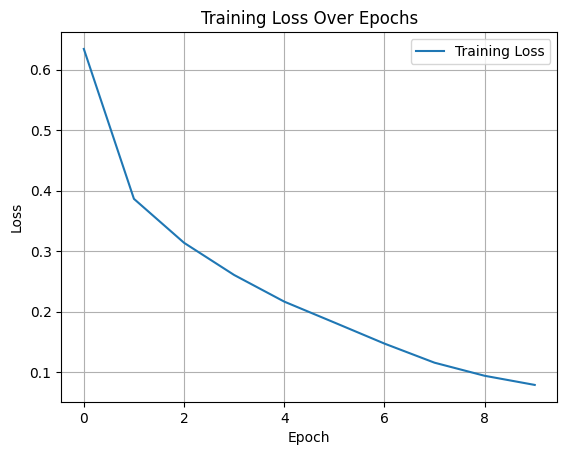

In [34]:
best_acc = 0
best_model = None
best_losses = []

dropout_rates = None
reg = None
reg_lambda = None
optim = "adam"
activations = ["relu", "tanh"]
layer_sizes = [1024, 512, 128]

model = ConvNN(layer_sizes=layer_sizes, activations=activations, dropout_rates=dropout_rates)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(f"\nTraining with layers: {layer_sizes}, activations: {activations}, optimizer: {optim}, regalurisation: {reg}, reg_lambda:{reg_lambda}, dropout_rates: {dropout_rates}")

acc, train_losses = train(Xtrain_standart, ytrain, Xval_standart, yval, model, optimizer, reg=reg, reg_lambda=reg_lambda)

print(f"Validation Accuracy: {acc:.4f}")

print_func(train_losses)


Best Result Achieved with MinMax Scaling

After testing the same CNN configuration with different normalization strategies (no normalization, `StandardScaler`, and `MinMaxScaler`), we observed that the **best validation accuracy was achieved using `MinMaxScaler`**.

### Testing Different Optimizers with Best Parameters and MinMax Scaling

In this section, we test different optimization algorithms such as **SGD** and **RMSprop** while keeping the **best-performing architecture and hyperparameters** found earlier. Since `MinMaxScaler` provided the best results in previous experiments, we continue using MinMax-normalized datasets (`Xtrain_minmax`, etc.) to ensure fair comparison.

This helps us understand how different optimizers affect the training dynamics and final performance when the rest of the configuration remains fixed.



Training with layers: [1024, 512, 128], activations: ['relu', 'tanh'], optimizer: SGD, regalurisation: None, reg_lambda:None, dropout_rates: None
Epoch 1/10, Loss: 4.7921
Epoch 2/10, Loss: 4.0739
Epoch 3/10, Loss: 2.3249
Epoch 4/10, Loss: 2.2237
Epoch 5/10, Loss: 2.1348
Epoch 6/10, Loss: 1.9713
Epoch 7/10, Loss: 1.7470
Epoch 8/10, Loss: 1.5546
Epoch 9/10, Loss: 1.4164
Epoch 10/10, Loss: 1.3205
Validation Accuracy: 0.5396


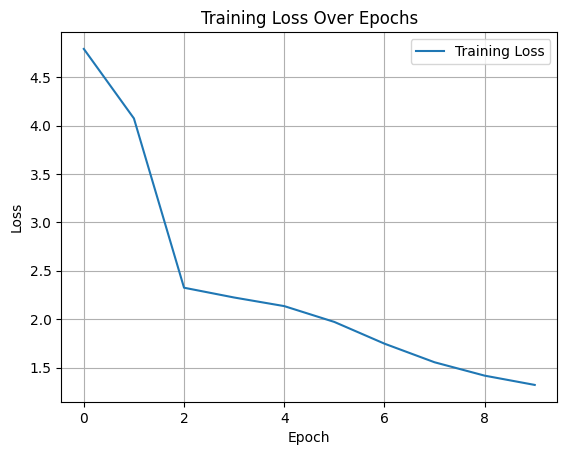

In [36]:
best_acc = 0
best_model = None
best_losses = []

dropout_rates = None
reg = None
reg_lambda = None
optim = "SGD"
activations = ["relu", "tanh"]
layer_sizes = [1024, 512, 128]

model = ConvNN(layer_sizes=layer_sizes, activations=activations, dropout_rates=dropout_rates)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

print(f"\nTraining with layers: {layer_sizes}, activations: {activations}, optimizer: {optim}, regalurisation: {reg}, reg_lambda:{reg_lambda}, dropout_rates: {dropout_rates}")

acc, train_losses = train(Xtrain_minmax, ytrain, Xval_minmax, yval, model, optimizer, reg=reg, reg_lambda=reg_lambda)

print(f"Validation Accuracy: {acc:.4f}")

print_func(train_losses)



Training with layers: [1024, 512, 128], activations: ['relu', 'tanh'], optimizer: RMSprop, regalurisation: None, reg_lambda:None, dropout_rates: None
Epoch 1/10, Loss: 0.9003
Epoch 2/10, Loss: 0.4550
Epoch 3/10, Loss: 0.3709
Epoch 4/10, Loss: 0.3192
Epoch 5/10, Loss: 0.2751
Epoch 6/10, Loss: 0.2421
Epoch 7/10, Loss: 0.2083
Epoch 8/10, Loss: 0.1783
Epoch 9/10, Loss: 0.1520
Epoch 10/10, Loss: 0.1274
Validation Accuracy: 0.8790


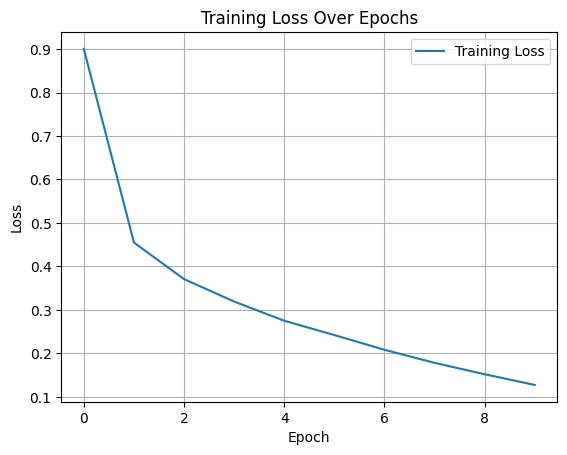

In [37]:
best_acc = 0
best_model = None
best_losses = []

dropout_rates = None
reg = None
reg_lambda = None
optim = "RMSprop"
activations = ["relu", "tanh"]
layer_sizes = [1024, 512, 128]

model = ConvNN(layer_sizes=layer_sizes, activations=activations, dropout_rates=dropout_rates)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)

print(f"\nTraining with layers: {layer_sizes}, activations: {activations}, optimizer: {optim}, regalurisation: {reg}, reg_lambda:{reg_lambda}, dropout_rates: {dropout_rates}")

acc, train_losses = train(Xtrain_minmax, ytrain, Xval_minmax, yval, model, optimizer, reg=reg, reg_lambda=reg_lambda)

print(f"Validation Accuracy: {acc:.4f}")

print_func(train_losses)


### RMSprop vs Adam Optimizer

Although **RMSprop** showed promising results with a validation accuracy of `0.8790`, it still did **not surpass the performance of the Adam optimizer**, which previously achieved a higher accuracy.

This confirms that, in this specific setup with the best-performing architecture and MinMax scaling, **Adam remains the most effective optimizer** for maximizing validation performance.


### Testing L1 and L2 Regularisation with Best Settings (No Dropouts)

In this section, we test **L1** and **L2** regularisation techniques using:

- The **Adam** optimizer (which previously showed the best results),
- The **MinMaxScaler** for normalization,
- The **best-performing model architecture** (layer sizes and activations),
- And **no dropout** layers to isolate the effect of regularisation.

By keeping all optimal parameters constant and only modifying the regularisation type and strength, we aim to observe whether adding regularisation alone can further improve performance or reduce overfitting without relying on dropout.



Training with layers: [1024, 512, 128], activations: ['relu', 'tanh'], optimizer: adam, regalurisation: l1, reg_lambda:0.001, dropout_rates: None
Epoch 1/10, Loss: 3.6411
Epoch 2/10, Loss: 1.9994
Epoch 3/10, Loss: 1.8138
Epoch 4/10, Loss: 1.6999
Epoch 5/10, Loss: 1.5859
Epoch 6/10, Loss: 1.5298
Epoch 7/10, Loss: 1.5013
Epoch 8/10, Loss: 1.4794
Epoch 9/10, Loss: 1.4590
Epoch 10/10, Loss: 1.4422
Validation Accuracy: 0.7935


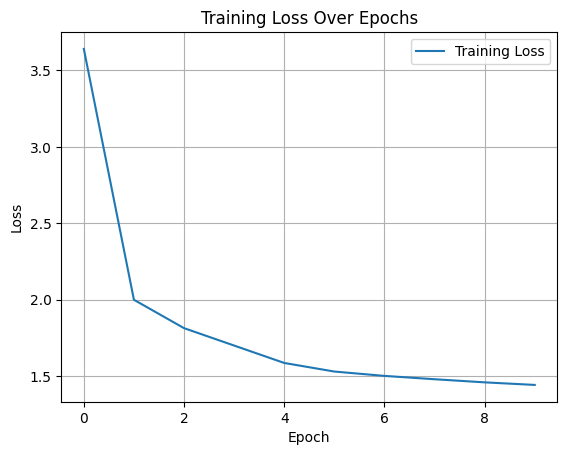

In [52]:
best_acc = 0
best_model = None
best_losses = []

dropout_rates = None
reg = "l1"
reg_lambda = None
optim = "adam"
activations = ["relu", "tanh"]
layer_sizes = [1024, 512, 128]
reg_lambda = 0.001

model = ConvNN(layer_sizes=layer_sizes, activations=activations, dropout_rates=dropout_rates)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(f"\nTraining with layers: {layer_sizes}, activations: {activations}, optimizer: {optim}, regalurisation: {reg}, reg_lambda:{reg_lambda}, dropout_rates: {dropout_rates}")

acc, train_losses = train(Xtrain_minmax, ytrain, Xval_minmax, yval, model, optimizer, reg=reg, reg_lambda=reg_lambda)

print(f"Validation Accuracy: {acc:.4f}")

print_func(train_losses)


Training with layers: [1024, 512, 128], activations: ['relu', 'tanh'], optimizer: adam, regalurisation: l2, reg_lambda:0.001, dropout_rates: None
Epoch 1/10, Loss: 0.7590
Epoch 2/10, Loss: 0.4847
Epoch 3/10, Loss: 0.4220
Epoch 4/10, Loss: 0.3868
Epoch 5/10, Loss: 0.3568
Epoch 6/10, Loss: 0.3300
Epoch 7/10, Loss: 0.3068
Epoch 8/10, Loss: 0.2850
Epoch 9/10, Loss: 0.2717
Epoch 10/10, Loss: 0.2492
Validation Accuracy: 0.8911


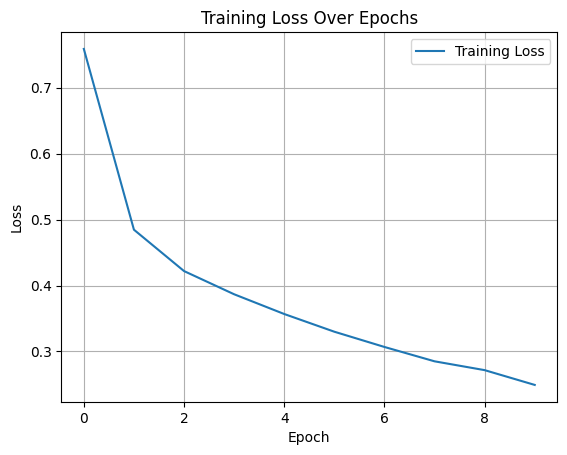

In [43]:
best_acc = 0
best_model = None
best_losses = []

dropout_rates = None
reg = "l2"
reg_lambda = None
optim = "adam"
activations = ["relu", "tanh"]
layer_sizes = [1024, 512, 128]
reg_lambda = 0.001

model = ConvNN(layer_sizes=layer_sizes, activations=activations, dropout_rates=dropout_rates)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(f"\nTraining with layers: {layer_sizes}, activations: {activations}, optimizer: {optim}, regalurisation: {reg}, reg_lambda:{reg_lambda}, dropout_rates: {dropout_rates}")

acc, train_losses = train(Xtrain_minmax, ytrain, Xval_minmax, yval, model, optimizer, reg=reg, reg_lambda=reg_lambda)

print(f"Validation Accuracy: {acc:.4f}")

print_func(train_losses)


### Applying Dropout Alongside Regularisation

Now we extend our experiment by introducing **dropout** on top of the previously used best-performing configuration:

- Optimizer: **Adam**
- Normalisation: **MinMaxScaler**
- Activation functions: **ReLU** and **Tanh**
- Layer sizes: **[1024, 512, 128]**
- Regularisation: **L1** with **reg_lambda = 0.001**
- **Dropout rates**: 0.3, 0.2


Training with layers: [1024, 512, 128], activations: ['relu', 'tanh'], optimizer: adam, regalurisation: l1, reg_lambda:0.001, dropout_rates: [0.3, 0.2]
Epoch 1/10, Loss: 3.4739
Epoch 2/10, Loss: 2.0207
Epoch 3/10, Loss: 1.8407
Epoch 4/10, Loss: 1.7095
Epoch 5/10, Loss: 1.6535
Epoch 6/10, Loss: 1.6191
Epoch 7/10, Loss: 1.5948
Epoch 8/10, Loss: 1.5853
Epoch 9/10, Loss: 1.5473
Epoch 10/10, Loss: 1.5381
Validation Accuracy: 0.7822


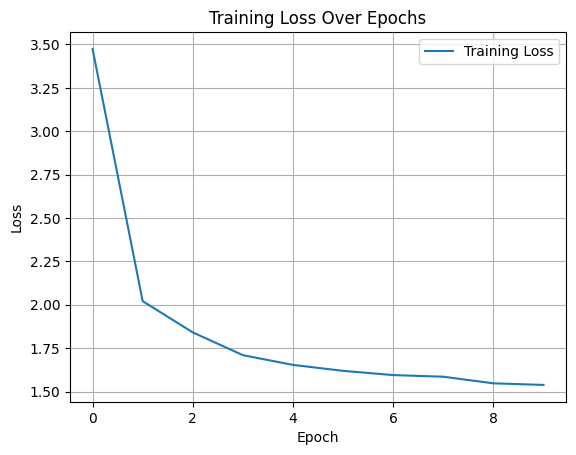

In [44]:
best_acc = 0
best_model = None
best_losses = []

dropout_rates = [0.3, 0.2]
reg = "l1"
reg_lambda = None
optim = "adam"
activations = ["relu", "tanh"]
layer_sizes = [1024, 512, 128]
reg_lambda = 0.001

model = ConvNN(layer_sizes=layer_sizes, activations=activations, dropout_rates=dropout_rates)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(f"\nTraining with layers: {layer_sizes}, activations: {activations}, optimizer: {optim}, regalurisation: {reg}, reg_lambda:{reg_lambda}, dropout_rates: {dropout_rates}")

acc, train_losses = train(Xtrain_minmax, ytrain, Xval_minmax, yval, model, optimizer, reg=reg, reg_lambda=reg_lambda)

print(f"Validation Accuracy: {acc:.4f}")

print_func(train_losses)



Training with layers: [1024, 512, 128], activations: ['relu', 'tanh'], optimizer: adam, regalurisation: l2, reg_lambda:0.001, dropout_rates: [0.3, 0.2]
Epoch 1/10, Loss: 0.8127
Epoch 2/10, Loss: 0.5506
Epoch 3/10, Loss: 0.4809
Epoch 4/10, Loss: 0.4443
Epoch 5/10, Loss: 0.4189
Epoch 6/10, Loss: 0.3936
Epoch 7/10, Loss: 0.3740
Epoch 8/10, Loss: 0.3615
Epoch 9/10, Loss: 0.3457
Epoch 10/10, Loss: 0.3304
Validation Accuracy: 0.8867


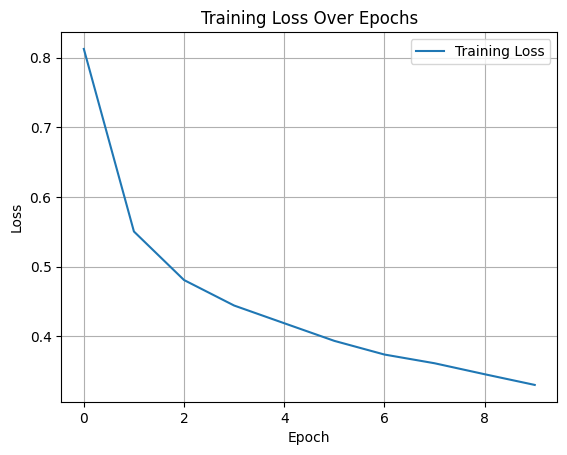

In [45]:
best_acc = 0
best_model = None
best_losses = []

dropout_rates = [0.3, 0.2]
reg = "l2"
reg_lambda = None
optim = "adam"
activations = ["relu", "tanh"]
layer_sizes = [1024, 512, 128]
reg_lambda = 0.001

model = ConvNN(layer_sizes=layer_sizes, activations=activations, dropout_rates=dropout_rates)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(f"\nTraining with layers: {layer_sizes}, activations: {activations}, optimizer: {optim}, regalurisation: {reg}, reg_lambda:{reg_lambda}, dropout_rates: {dropout_rates}")

acc, train_losses = train(Xtrain_minmax, ytrain, Xval_minmax, yval, model, optimizer, reg=reg, reg_lambda=reg_lambda)

print(f"Validation Accuracy: {acc:.4f}")

print_func(train_losses)


#### Without Dropouts:
We tested both `L1` and `L2` regularisations without any dropout. The results varied:
- **L2 regularisation** achieved a validation accuracy of **0.8911**, showing very strong performance.
- **L1 regularisation**, on the other hand, performed worse with a validation accuracy of around **0.7935**.

#### With Dropouts:
Dropout rates of `[0.3, 0.2]` were applied to the convolutional layers along with the same regularisation strategies:
- **L2 + Dropout** led to a slightly lower performance of **0.8867** compared to L2 without dropout.
- **L1 + Dropout** also performed worse than its no-dropout counterpart, reaching only **0.7822** accuracy.

#### Conclusion:
Overall, **L2 regularisation without dropouts** gave the **best validation accuracy** among all combinations

### Final Model Training

After extensive experimentation with various normalization techniques (including `StandardScaler` and `MinMaxScaler`), optimizers (like `Adam`, `SGD`, `RMSprop`), and regularization methods (L1, L2 with and without dropouts), we observed that the best result across all combinations was achieved with the following configuration:

- **Normalization**: `MinMaxScaler`
- **Optimizer**: `Adam`
- **Regularization**: None
- **Dropouts**: None
- **Layer sizes**: `[1024, 512, 128]`
- **Activations**: `['relu', 'tanh']`
- **Validation Accuracy**: **0.8969**

Given this, we proceed to train our **final model** using this optimal configuration with an extended training period of **30 epochs** to potentially further improve performance.



Training with layers: [1024, 512, 128], activations: ['relu', 'tanh'], optimizer: adam, regalurisation: None, reg_lambda:None, dropout_rates: None
Epoch 1/29, Loss: 0.7171
Epoch 2/29, Loss: 0.4321
Epoch 3/29, Loss: 0.3593
Epoch 4/29, Loss: 0.3065
Epoch 5/29, Loss: 0.2701
Epoch 6/29, Loss: 0.2301
Epoch 7/29, Loss: 0.1996
Epoch 8/29, Loss: 0.1700
Epoch 9/29, Loss: 0.1384
Epoch 10/29, Loss: 0.1201
Epoch 11/29, Loss: 0.1051
Epoch 12/29, Loss: 0.0797
Epoch 13/29, Loss: 0.0651
Epoch 14/29, Loss: 0.0630
Epoch 15/29, Loss: 0.0569
Epoch 16/29, Loss: 0.0422
Epoch 17/29, Loss: 0.0465
Epoch 18/29, Loss: 0.0369
Epoch 19/29, Loss: 0.0371
Epoch 20/29, Loss: 0.0275
Epoch 21/29, Loss: 0.0439
Epoch 22/29, Loss: 0.0281
Epoch 23/29, Loss: 0.0271
Epoch 24/29, Loss: 0.0229
Epoch 25/29, Loss: 0.0206
Epoch 26/29, Loss: 0.0274
Epoch 27/29, Loss: 0.0329
Epoch 28/29, Loss: 0.0286
Epoch 29/29, Loss: 0.0174
Validation Accuracy: 0.8869


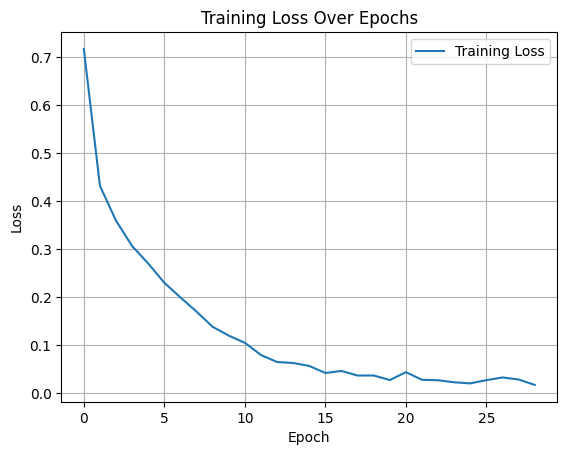

In [68]:
best_acc = 0
best_model = None
best_losses = []

dropout_rates = None
reg = None
reg_lambda = None
optim = "adam"
activations = ["relu", "tanh"]
layer_sizes = [1024, 512, 128]

model = ConvNN(layer_sizes=layer_sizes, activations=activations, dropout_rates=dropout_rates)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(f"\nTraining with layers: {layer_sizes}, activations: {activations}, optimizer: {optim}, regalurisation: {reg}, reg_lambda:{reg_lambda}, dropout_rates: {dropout_rates}")

acc, train_losses = train(Xtrain_minmax, ytrain, Xval_minmax, yval, model, optimizer, epochs=29, reg=reg, reg_lambda=reg_lambda)

print(f"Validation Accuracy: {acc:.4f}")

print_func(train_losses)

In [74]:
def predict_model(model, loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for xb in loader:  
            xb = xb[0]     
            preds = model(xb)
            pred_labels = preds.argmax(dim=1)
            predictions.extend(pred_labels.cpu().numpy())
    return predictions


In [75]:
from sklearn.metrics import accuracy_score

Xtest_scaled = minmax.transform(Xtest)
Xtest_tensor = torch.tensor(Xtest_scaled, dtype=torch.float32)

ytest_tensor = to_tensor(ytest, dtype=torch.long)

test_dataset = TensorDataset(Xtest_tensor, ytest_tensor)
test_loader = DataLoader(test_dataset, batch_size=64)

test_result = predict_model(model, test_loader)
print(f"Accuracy rate is {accuracy_score(ytest, test_result)}")

Accuracy rate is 0.8868571428571429


### Final accuracy is 0.89